







































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































<h2>Kinyrwanda HateSpeech Detection<h2>

- import libraries

In [27]:
import pandas as pd
import re
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

- import generated dataset

In [28]:
df = pd.read_csv('kinyarwanda_hard_texts.csv')
df.head()

,text,label
0,"Noneho Ndumva Ubwo Hahaha, ntacyo, murakoze cy...",sarcasm/joke
1,Hmmm Ngo Ngo Ngo Abanzi b’igihugu bakwiye guku...,hate
2,Noneho Murakoze Ngo Ngo Ndumva Iyo myitwarire ...,hate
3,"Murakoze Ndumva Hahaha, ntacyo, murakoze cyane...",sarcasm/joke
4,"Hmmm Ubwo Hahaha, ntacyo, murakoze cyane pe, n...",sarcasm/joke


In [29]:
df.shape

(17073, 2)

- load Scraped dataset

<h3>Data Preprcessing <h3> <br>

- lowercase <br>
- remove punctuations <br>
- remove whitespaces <br>
- remove user handles '@', links and digits <br>
- remove stopwords

In [30]:
kinyarwanda_stopwords = set([
    "na", "ku", "mu", "ya", "y'", "n'", "bya", "cyane", "rwose",
    "kandi", "ubwo", "uko", "ntacyo", "ntukwiye"
])

# Combine both sets
combined_stopwords = kinyarwanda_stopwords.union(ENGLISH_STOP_WORDS)
extra_stopwords = {"lol", "lmao", "smh", "bruh", "nah", "omg", "uhh", "hmm", "yo", "yup"}
combined_stopwords = combined_stopwords.union(extra_stopwords)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'@\w+|http\S+|\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    words = [word for word in words if word not in combined_stopwords]
    
    return ' '.join(words)

- Apply preprocessing to both datasets

In [ ]:
df['clean_text'] = df['text'].apply(preprocess_text)

- Save cleaned versions

- Label Encoding

In [35]:
df['label'].value_counts()
print("Label classes distribution")
print(df['label'].value_counts(normalize=True))

Label classes distribution
label
normal          0.438353
sarcasm/joke    0.281556
hate            0.280091
Name: proportion, dtype: float64


In [36]:
# print("Before Oversampling:\n", df_merged['label'].value_counts())
# df_normal = df_merged[df_merged['label'] == 'normal']
# df_offensive = df_merged[df_merged['label'] == 'offensive']
# df_hate = df_merged[df_merged['label'] == 'hate']

# #Find max class size
# max_size = max(len(df_normal), len(df_offensive), len(df_hate))

# #Oversample minority classes
# df_offensive_upsampled = resample(df_offensive, replace=True, n_samples=max_size, random_state=42)
# # df_normal_upsampled = resample(df_normal, replace=True, n_samples=max_size, random_state=42)

# df_balanced = pd.concat([df_normal, df_offensive_upsampled, df_hate])
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the data

# print("After Oversampling:\n", df_balanced['label'].value_counts())


In [37]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

- Vectorization with Tfidf

In [38]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=8000)
x = vectorizer.fit_transform(df['clean_text'])
y = df['label_encoded']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<h3> Model Development<h3>

- Using Logistic regression with balanced wiehts

In [40]:
print(le.classes_)

['hate' 'normal' 'sarcasm/joke']


In [41]:
lr = LogisticRegression(
    # max_iter=2000, 
    # class_weight={1: 1.0, 2: 2.0, 0: 1.0},
    # C=2.0
    class_weight = "balanced"
)

lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

<h3> Model Evaluation<h3>

In [42]:
y_pred = lr.predict(x_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Logistic Regression
              precision    recall  f1-score   support

        hate       0.98      0.98      0.98       959
      normal       0.99      0.99      0.99      1507
sarcasm/joke       0.99      0.99      0.99       949

    accuracy                           0.99      3415
   macro avg       0.99      0.99      0.99      3415
weighted avg       0.99      0.99      0.99      3415



In [43]:
print("Evaluation Results")
print("Accuracy:", accuracy_score(y_test, y_pred).__round__(2))
print("Precision:", precision_score(y_test, y_pred, average='weighted').__round__(2))
print("Recall:", recall_score(y_test, y_pred, average='weighted').__round__(2))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted').__round__(2))

Evaluation Results
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-Score: 0.99


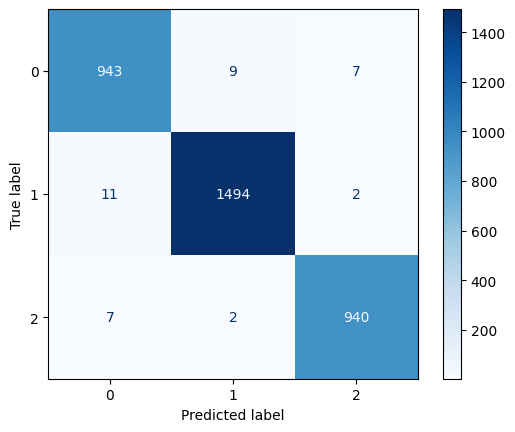

In [44]:
conf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf).plot(cmap="Blues")

- Save model, encoder, and vectorizer for deployment

In [45]:
joblib.dump(lr, "lr_model.pkl")
joblib.dump(vectorizer, "tfidf.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

- Test samples

In [46]:
test_tweets = [
    "Muraho Sha Noneho Bro Abagome Inzangano Urupfu smh",
    "Sure kabisa Hhh Ndabyemeye rwose Nuko se! lol",
    "Turashima Umugisha Umutuzo Ikirere Sha",
    "Ariko Sha Abagome Inda nini Ngo urankunda? bro",
    "Mbega Ese Cyane Sha Amakuru Ndakunda Ubuzima",
    "Ngo urankunda? Hahaha Nuko se! Sure kabisa lol",
    "Muraho Sha Sha Amahoro Ikirere Umugisha",
    "Abagome Inzangano Ntacyo mumaze Ikigarasha Sha",
    "Ndabyemeye rwose Sha Noneho Sure kabisa Hahaha",
    "Turashima Amakuru Umutuzo Umugisha Bro",
    "Sha Abagome Ibinyoma Inda nini smh",
    "Hhh Sure kabisa Ngo urankunda? Sha lol",
    "Muraho Amahoro Ikirere Umugisha Sha",
    "Ariko Abagome Urupfu Inzangano bro",
    "Sure kabisa Nuko se! Ndabyemeye rwose Hahaha",
    "Turashima Umugisha Ubuzima Ikirere Sha",
    "Abagome Inzangano Sha Inda nini bro",
    "Ngo urankunda? Sure kabisa Hahaha Sha",
    "Muraho Ndakunda Umutuzo Umugisha Ikirere",
    "Ariko Sha Abagome Inda nini smh",
    "Hhh Sure kabisa Nuko se! Sha lol",
    "Turashima Umugisha Umutuzo Amakuru",
    "Abagome Sha Inzangano Urupfu bro",
    "Sure kabisa Ndabyemeye rwose Hahaha Sha",
    "Muraho Amakuru Umugisha Umutuzo Sha",
    "Abagome Ntacyo mumaze Inzangano smh",
    "Hhh Sure kabisa Nuko se! Sha lol",
    "Turashima Umugisha Ikirere Umutuzo",
    "Abagome Urupfu Sha Inzangano bro",
    "Sure kabisa Hahaha Ndabyemeye rwose Sha",
    "Muraho Ndakunda Amakuru Umugisha",
    "Sha Abagome Inzangano Urupfu smh",
    "Hhh Sure kabisa Sha Nuko se! lol",
    "Turashima Umugisha Umutuzo Sha",
    "Abagome Inzangano Ntacyo mumaze bro",
    "Sure kabisa Sha Hahaha Ndabyemeye rwose",
    "Muraho Amakuru Umugisha Ikirere",
    "Abagome Urupfu Sha Inzangano smh",
    "Hhh Sure kabisa Nuko se! Sha lol",
    "Turashima Umugisha Umutuzo Amakuru",
    "Abagome Sha Inzangano Urupfu bro",
    "Sure kabisa Ndabyemeye rwose Hahaha Sha",
    "Muraho Ndakunda Umugisha Umutuzo",
    "Sha Abagome Inzangano Urupfu smh",
    "Hhh Sure kabisa Sha Nuko se! lol",
    "Turashima Umugisha Umutuzo Ikirere",
    "Abagome Inzangano Sha Urupfu bro",
    "Sure kabisa Hahaha Ndabyemeye rwose Sha",
    "Muraho Ndakunda Umutuzo Amakuru",
    "Sha Abagome Inzangano Urupfu smh"
]

for tweet in test_tweets:
    clean_text = preprocess_text(tweet)
    vectorized_text = vectorizer.transform([clean_text])
    prediction = lr.predict(vectorized_text)
    label = le.inverse_transform(prediction)[0]
    print(f"Tweet: {tweet}\nPredicted Label: {label}\n")

Tweet: Muraho Sha Noneho Bro Abagome Inzangano Urupfu smh
Predicted Label: hate

Tweet: Sure kabisa Hhh Ndabyemeye rwose Nuko se! lol
Predicted Label: sarcasm/joke

Tweet: Turashima Umugisha Umutuzo Ikirere Sha
Predicted Label: normal



Tweet: Ariko Sha Abagome Inda nini Ngo urankunda? bro
Predicted Label: hate

Tweet: Mbega Ese Cyane Sha Amakuru Ndakunda Ubuzima
Predicted Label: normal

Tweet: Ngo urankunda? Hahaha Nuko se! Sure kabisa lol
Predicted Label: sarcasm/joke

Tweet: Muraho Sha Sha Amahoro Ikirere Umugisha
Predicted Label: normal

Tweet: Abagome Inzangano Ntacyo mumaze Ikigarasha Sha
Predicted Label: hate

Tweet: Ndabyemeye rwose Sha Noneho Sure kabisa Hahaha
Predicted Label: sarcasm/joke

Tweet: Turashima Amakuru Umutuzo Umugisha Bro
Predicted Label: normal

Tweet: Sha Abagome Ibinyoma Inda nini smh
Predicted Label: hate

Tweet: Hhh Sure kabisa Ngo urankunda? Sha lol
Predicted Label: sarcasm/joke

Tweet: Muraho Amahoro Ikirere Umugisha Sha
Predicted Label: normal

Tweet: Ariko Abagome Urupfu Inzangano bro
Predicted Label: hate

Tweet: Sure kabisa Nuko se! Ndabyemeye rwose Hahaha
Predicted Label: sarcasm/joke

Tweet: Turashima Umugisha Ubuzima Ikirere Sha
Predicted Label: normal

Tweet: Abagome Inzangano Sh

In [47]:
hard_test_texts = [
    # 1. Polite but hateful context
    "Murakoze cyane ariko mwese ntacyo mumaze sha",
    
    # 2. Sarcasm that looks normal at first glance
    "Yego mwakoze neza kabisa",
    
    # 3. Normal text with mild negative word but no hate
    "Ndakunda ubuzima ariko inzangano zirambabaza",
    
    # 4. Sarcasm/joke using local slang
    "Ngo urankunda? bro sure sure hahaha",
    
    # 5. Hate speech with normal filler
    "Muraho neza ariko abagome nkamwe murarenga",
    
    # 6. Neutral statement that could be misread
    "Sha ese ibyo byose ni byo koko?",
    
    # 7. Polite sarcastic closure
    "Turashima ibikorwa byanyu koko rwose",
    
    # 8. Mixed code-switch, indirect insult
    "Bro sha inda nini yanyu smh",
    
    # 9. Passive aggressive sarcasm
    "Ni byiza cyane uko mukora neza kabisa",
    
    # 10. Normal but ironically worded
    "Ndabashimira cyane kubera ibyo byose"
]

for tweet in hard_test_texts:
    clean_text = preprocess_text(tweet)
    vectorized_text = vectorizer.transform([clean_text])
    prediction = lr.predict(vectorized_text)
    label = le.inverse_transform(prediction)[0]
    print(f"Tweet: {tweet}\nPredicted Label: {label}\n")

Tweet: Murakoze cyane ariko mwese ntacyo mumaze sha
Predicted Label: hate

Tweet: Yego mwakoze neza kabisa
Predicted Label: sarcasm/joke

Tweet: Ndakunda ubuzima ariko inzangano zirambabaza
Predicted Label: normal

Tweet: Ngo urankunda? bro sure sure hahaha
Predicted Label: sarcasm/joke

Tweet: Muraho neza ariko abagome nkamwe murarenga
Predicted Label: hate

Tweet: Sha ese ibyo byose ni byo koko?
Predicted Label: sarcasm/joke

Tweet: Turashima ibikorwa byanyu koko rwose
Predicted Label: normal

Tweet: Bro sha inda nini yanyu smh
Predicted Label: hate

Tweet: Ni byiza cyane uko mukora neza kabisa
Predicted Label: sarcasm/joke

Tweet: Ndabashimira cyane kubera ibyo byose
Predicted Label: normal



In [48]:
harder_test_texts = [
    "Sha ese ibyo uvuga birumvikana koko?",
    "Turashima cyane imirimo yanyu, rwose ntawurusha",
    "Abagome baracyahari, nubwo mwavuga utuntu",
    "Ngo urankunda koko? Naho ndi indaya ngo",
    "Ese koko ibyo mukora ni byiza ku gihugu?",
    "Murakoze kubw’uruhare rwanyu, nyamara ibibazo birahari",
    "Bro, inda nini iraguhenda, ntugize inama",
    "Icyo navuga ni uko byose ari urwenya gusa",
    "Yego rwose, nta wundi mwanya w’ingenzi mfite",
    "Ndumva ibyo muvuga ari ukuri, ntacyo nabivugaho",
    "Abanzi barategereje ko twitandukanya, ndabyumva",
    "Ngo urankunda? Hahaha, ubwo uri umunyabinyoma",
    "Ese koko mwumva ibyo byose ari ibisubizo?",
    "Turashima uruhare rwawe, gusa biracyakomeye",
    "Abagome bakiriho, ntituzabireka",
    "Bro, inda nini yanyu ntizigera ikiza",
    "Ndumva ibyanyu ari ibihuha gusa, nta gihamya mfite",
    "Yego kabisa, imirimo yanyu iratangaje cyane",
    "Ntacyo twakora tutari kumwe, turashimira cyane",
    "Ese ibyo uvuga ni ukuri cyangwa urwenya?"
]

for tweet in harder_test_texts:
    clean_text = preprocess_text(tweet)
    vectorized_text = vectorizer.transform([clean_text])
    prediction = lr.predict(vectorized_text)
    label = le.inverse_transform(prediction)[0]
    print(f"Tweet: {tweet}\nPredicted Label: {label}\n")
    

Tweet: Sha ese ibyo uvuga birumvikana koko?
Predicted Label: normal

Tweet: Turashima cyane imirimo yanyu, rwose ntawurusha
Predicted Label: normal

Tweet: Abagome baracyahari, nubwo mwavuga utuntu
Predicted Label: hate

Tweet: Ngo urankunda koko? Naho ndi indaya ngo
Predicted Label: sarcasm/joke

Tweet: Ese koko ibyo mukora ni byiza ku gihugu?
Predicted Label: sarcasm/joke

Tweet: Murakoze kubw’uruhare rwanyu, nyamara ibibazo birahari
Predicted Label: sarcasm/joke

Tweet: Bro, inda nini iraguhenda, ntugize inama
Predicted Label: hate

Tweet: Icyo navuga ni uko byose ari urwenya gusa
Predicted Label: sarcasm/joke

Tweet: Yego rwose, nta wundi mwanya w’ingenzi mfite
Predicted Label: normal

Tweet: Ndumva ibyo muvuga ari ukuri, ntacyo nabivugaho
Predicted Label: sarcasm/joke

Tweet: Abanzi barategereje ko twitandukanya, ndabyumva
Predicted Label: hate

Tweet: Ngo urankunda? Hahaha, ubwo uri umunyabinyoma
Predicted Label: sarcasm/joke

Tweet: Ese koko mwumva ibyo byose ari ibisubizo?
Pred